In [1]:
using Plots
pyplot()
using MyBioTools.FluTools
using TreeTools
using StatsBase
using Dates
using Measures
# using Interpolations
using Dierckx
using StatsPlots
using KernelDensity
include("../../../make_all_plots.jl")

┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/MyBioTools.ji for MyBioTools [top-level]
└ @ Base loading.jl:1184


Pfix_vs_fitness (generic function with 1 method)

In [2]:
plot(rand(10));

In [3]:
lfs = 16 # Legend font size
alfs = 18 # axis label font size
tfs = 18 # title font size
atfs = 18 # axis ticks font size
ga = 0.3 # grid alpha
sizes = (1200,800) # standard size for single plots
rl = 0.065 # position of the "A" or "B" label in % 
ms = 6 # marker size
ls = 6 # line size
plotfolder = "ShortTerm"

"ShortTerm"

In [4]:
sp = FluTools.StrainPop("../../data/aligned_h3n2_ha_aa.fasta", strain="h3n2");

In [5]:
binwidth = Day(30);
binspacing = Day(60);
FluTools.bin_by_date!(sp, binwidth=binwidth, binspacing = binspacing);

In [6]:
ph_all = FluTools.positions_history(sp);

In [7]:
trajectories = FluTools.all_trajectories(ph_all, keep_unfinished=true)
trajectories = FluTools.previous_state_condition(trajectories, :lost)
trajectories = FluTools.population_size_condition(trajectories, 10);
trajectories = FluTools.min_frequency_condition(trajectories, 0.25);

In [8]:
length(trajectories)

116

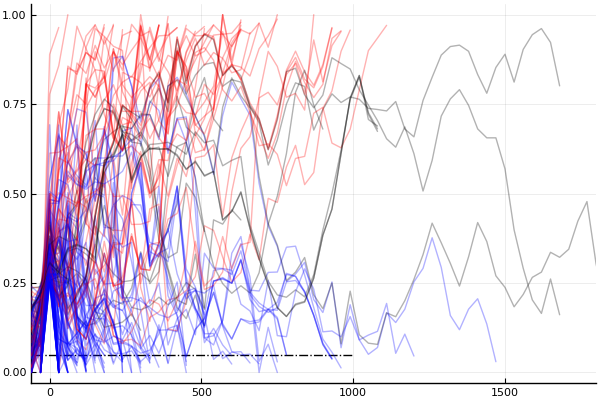

In [28]:
p = plot([-100, 1000], [0.05, 0.05], line=(:black, :dashdot), label="")
for traj in trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        istart = traj.index[:start]; iend = traj.index[:end]
        if traj.fixation==:lost
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label="", alpha=0.3, color=:blue)
        elseif traj.fixation==:fixed
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label="", alpha=0.3, color=:red)
        else
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label="", alpha=0.3, color=:black)
        end
    end
end
plot!(p, xlim=(-60,1800))

In [9]:
activity_dict = Dict()
max_t = 10*365
dt = binspacing.value
for traj in trajectories
    tmp = Dict()
    i = findfirst(x->x==traj.fixation, [:fixed, :lost])
    for t in [x.value for x in traj.t[2:end-1]] .- traj.t[1].value .- dt
        tmp[t] = get(tmp, t, [0,0,0]) + [1,0,0]
    end
    
    for t in (traj.t[end].value - traj.t[1].value - dt):dt:max_t
        tmp[t] = get(tmp, t, [0,0,0]) + Int64.([0,traj.fixation==:lost,traj.fixation==:fixed])
#         tmp[t][1] = tmp[t-30][1]
    end
    
    for (t,v) in tmp
        activity_dict[t] = get(activity_dict, t, [0,0,0]) + tmp[t]
    end
end


In [10]:
active = [x[1]/sum(x) for x in values(activity_dict)]
lost = [x[2]/sum(x) for x in values(activity_dict)]
fixed = [x[3]/sum(x) for x in values(activity_dict)];
n = [Float64(sum(x)) for x in values(activity_dict)]
times = collect(keys(activity_dict))
tmp = sortperm(times)
active = Float64.(active[tmp]); lost = Float64.(lost[tmp]); fixed = Float64.(fixed[tmp]); times = Float64.(times[tmp]); n = n[tmp];
# plot(times, active)
# times .+= 0.1;

In [31]:
length(trajectories)

150

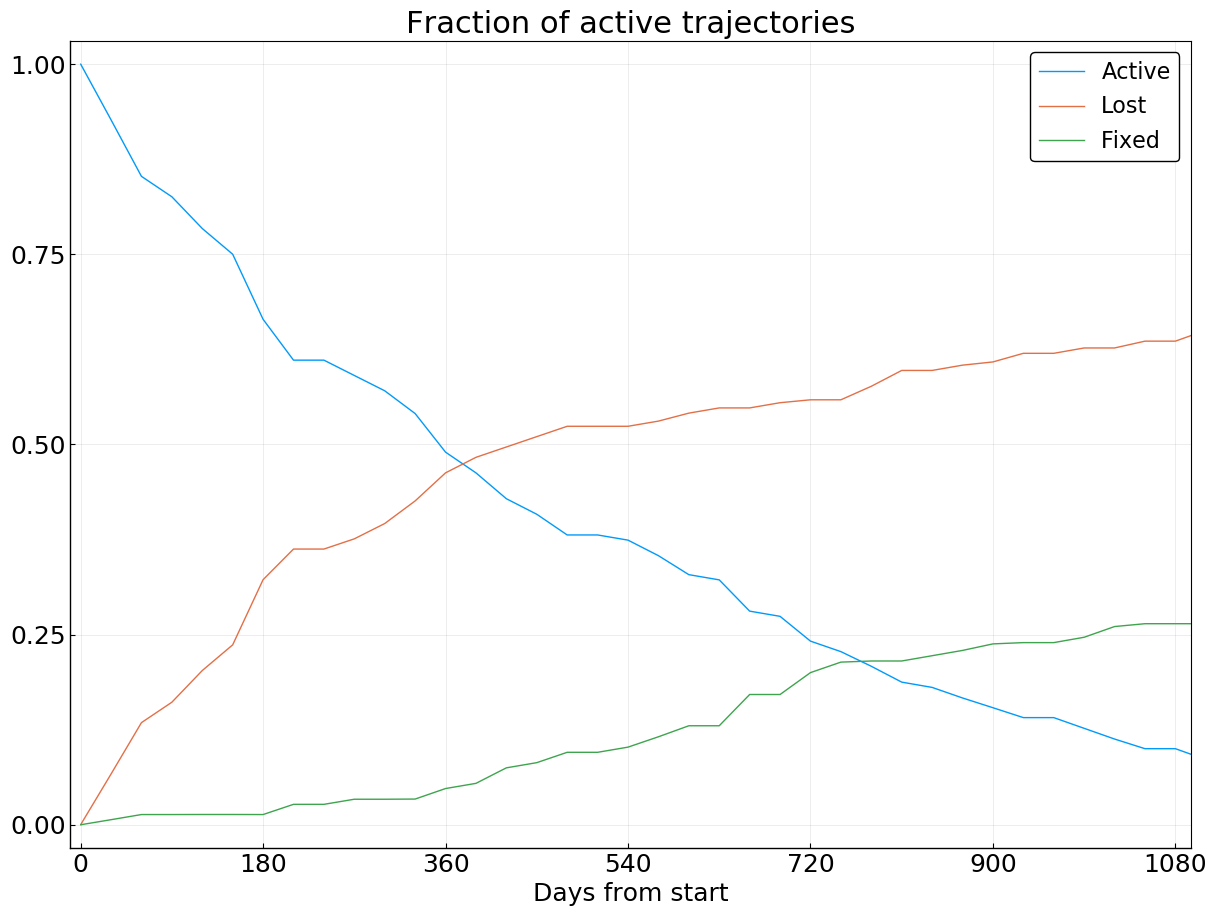

In [335]:
p = plot(times, active, label="Active")
plot!(times, lost, label="Lost")
plot!(times, fixed, label="Fixed")
plot!(xlim = (-10,3*365))
plot!(xticks=[i*180 for i in 0:6])
plot!(p,size=(1200,900),frame=:box, title="Fraction of active trajectories", xlabel="Days from start", tickfontsize=tfs, legendfontsize=lfs, guidefontsize=alfs,titlefontsize=22)
savefig("ShortTerm/trajectory_duration_minfreq25.png")

# Propagator

In [11]:
binwidth = Day(15);
binspacing = Day(30);
FluTools.bin_by_date!(sp, binwidth=binwidth, binspacing = binspacing);

In [12]:
ph_all = FluTools.positions_history(sp);

In [9]:
trajectories = FluTools.all_trajectories(ph_all, keep_unfinished=true)
trajectories = FluTools.previous_state_condition(trajectories, :lost)
trajectories = FluTools.frequency_condition(trajectories, 0.3, dα=0.05);
trajectories = FluTools.population_size_condition(trajectories, 20, mode = :overall);

UndefVarError: UndefVarError: Flu not defined

In [69]:
length(trajectories)

75

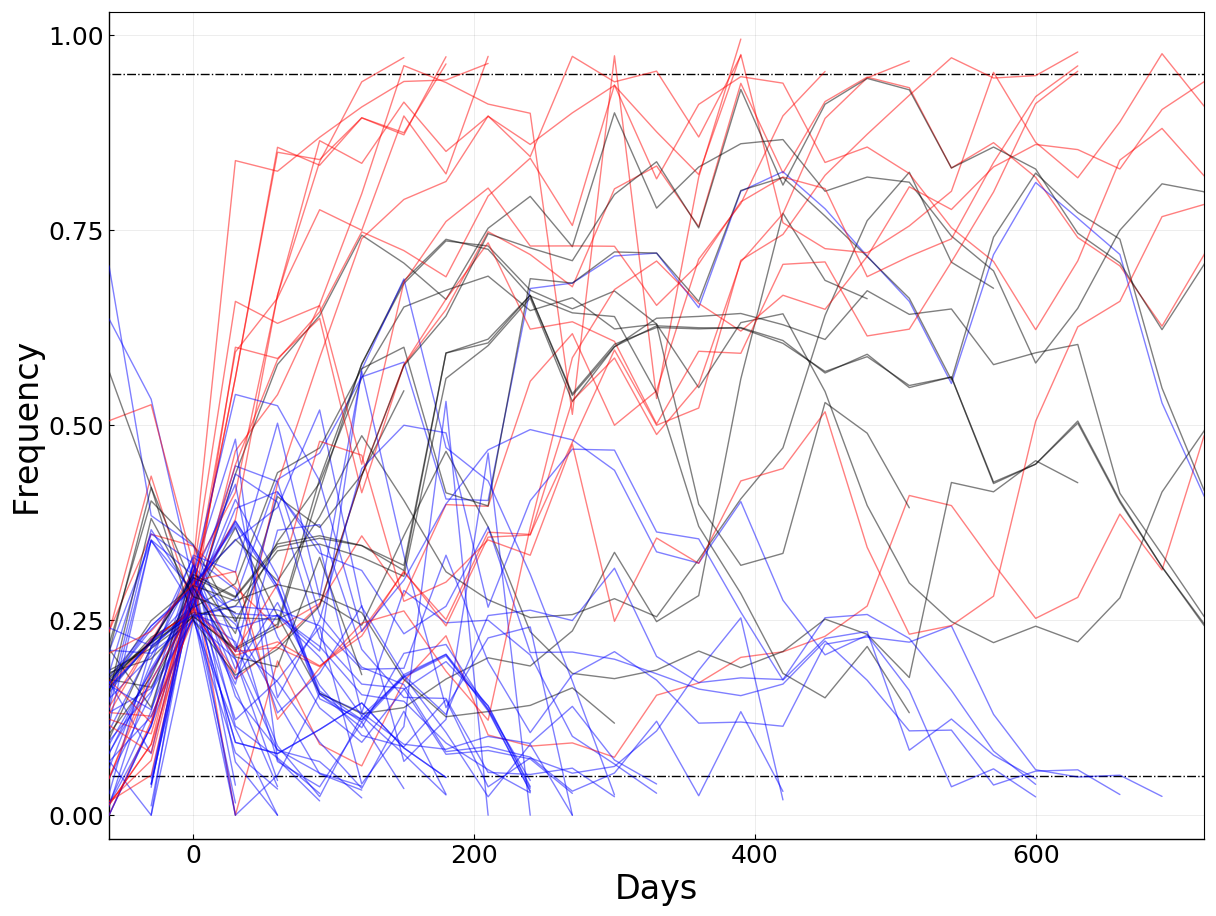

In [79]:
nfix = length(findall(x->x.fixation==:fixed, trajectories))
nlost = length(findall(x->x.fixation==:lost, trajectories))
nactive = length(findall(x->x.fixation==:poly, trajectories))
#
p = plot([-100, 1000], [0.05, 0.05], line=(:black, :dashdot), label="")
plot!(p, [-100, 1000], [0.95, 0.95], line=(:black, :dashdot), label="")
actflag = false; fixflag = false; lostflag=false;
for traj in trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        istart = traj.index[:start]; iend = traj.index[:end]
        if traj.fixation==:lost
#             lab = lostflag ? "" : "Lost - $nlost"
            lab = ""
            lostflag=true
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label=lab, alpha=0.5, color=:blue)
        elseif traj.fixation==:fixed
#             lab = fixflag ? "" : "Fixed - $nfix"
            lab = ""
            fixflag=true
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label=lab, alpha=0.5, color=:red)
        else
#             lab = actflag ? "" : "Active - $nactive"
            lab = ""
            actflag=true
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label=lab, alpha=0.5, color=:black)
        end
    end
end
plot!(p, xlim=(-60,720))
plot!(p, size=(1200,900), frame=:box, tickfontsize=atfs, guidefontsize=24, legendfontsize=lfs)
plot!(xlabel="Days", ylabel="Frequency")
savefig("ShortTerm/all_03_trajectories.png")

In [71]:
length(trajectories)

75

In [72]:
dat = Dict()
for traj in trajectories
    is = traj.index[:active]
    ie = is+48
    for i in is:ie
        if i > length(traj.t)
            t = (i-is)*binspacing.value
            traj.fixation != :poly && push!(get!(dat,t,Float64[]), traj.fixation==:fixed ? 1. : 0.)
        else
            push!(get!(dat,traj.t[i].value,Float64[]), traj.freq[i])
        end
    end
end

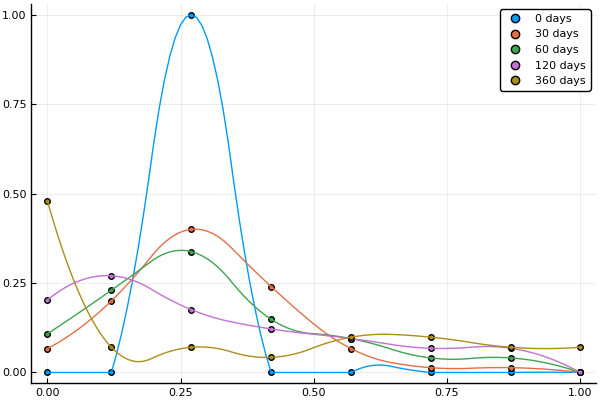

In [73]:
p = plot()
entropy_v_time = []
bins = vcat(0., collect(0.05:0.15:0.95), 1.001)
xs = vcat(0., collect(0.12:0.15:0.87), 1.)
for (i,t) in enumerate([0,30,60,120,360])
    h = fit(Histogram, dat[t], bins)
    ys = h.weights/sum(h.weights)
    scatter!(p, xs, ys, label="$t days", color=i)
    # Fitting a spline
    itp = Spline1D(xs, ys,k=2)
    x = 0.0:0.01:1.
    plot!(p, x, max.(itp(x),0.), label="", color=i)
    push!(entropy_v_time, [t StatsBase.entropy(h.weights/sum(h.weights))])
end
p

In [99]:
pa = []
entropy_v_time = []
bins = vcat(0., collect(0.05:0.15:0.95), 1.001)
xs = vcat(0., collect(0.12:0.15:0.87), 1.)

tvalues = [0,30,60,120,360,720]
for (i,t) in enumerate(tvalues)
    h = fit(Histogram, dat[t], bins)
    y = h.weights/sum(h.weights)
    # Fitting a spline
#     itp = CubicSplineInterpolation(xs, y[2:end-1])
    itp = Spline1D(xs,y,k=2)
    itplin = Spline1D(xs,y,k=1)
    f(x) = itplin(x)==0. ? 0. : (itplin(x) == 1. ? 1. : itp(x))
    x = min(xs...):0.01:max(xs...)
    # 
    push!(entropy_v_time, [t StatsBase.entropy(h.weights/sum(h.weights))])
    # Plot
    p = scatter(xs, y, label="$t days", color=i, markerstrokewidth=0.5, markersize=10) # data
    plot!(p, x, f.(x), label="", color=i, linewidth=3)
    plot!(p, size=(1000,200), ylim=(-0.05,1.05), xlim=(-0.05,1.05), yticks=[0.,0.5,1.], legendfontsize=lfs)
    plot!(xticks=(vcat(0., collect(0.05:0.15:0.95), 1.0), ["0",0.05,0.2,0.35,0.5,0.65,0.8,0.95,"1"]))
    plot!(ytickfontsize=16)
#     plot!(xticks=(vcat(0., collect(0.05:0.15:0.95), 1.0))
    if i == length(tvalues) || i == div(length(tvalues),2)
        plot!(p, xlabel="Frequency of mutation", guidefontsize=alfs,xtickfontsize=16)
    else
        plot!(p, xlabelfontsize=0, xtickfontsize=0)
    end
    push!(pa, p)
end
entropy_v_time = vcat(entropy_v_time...);

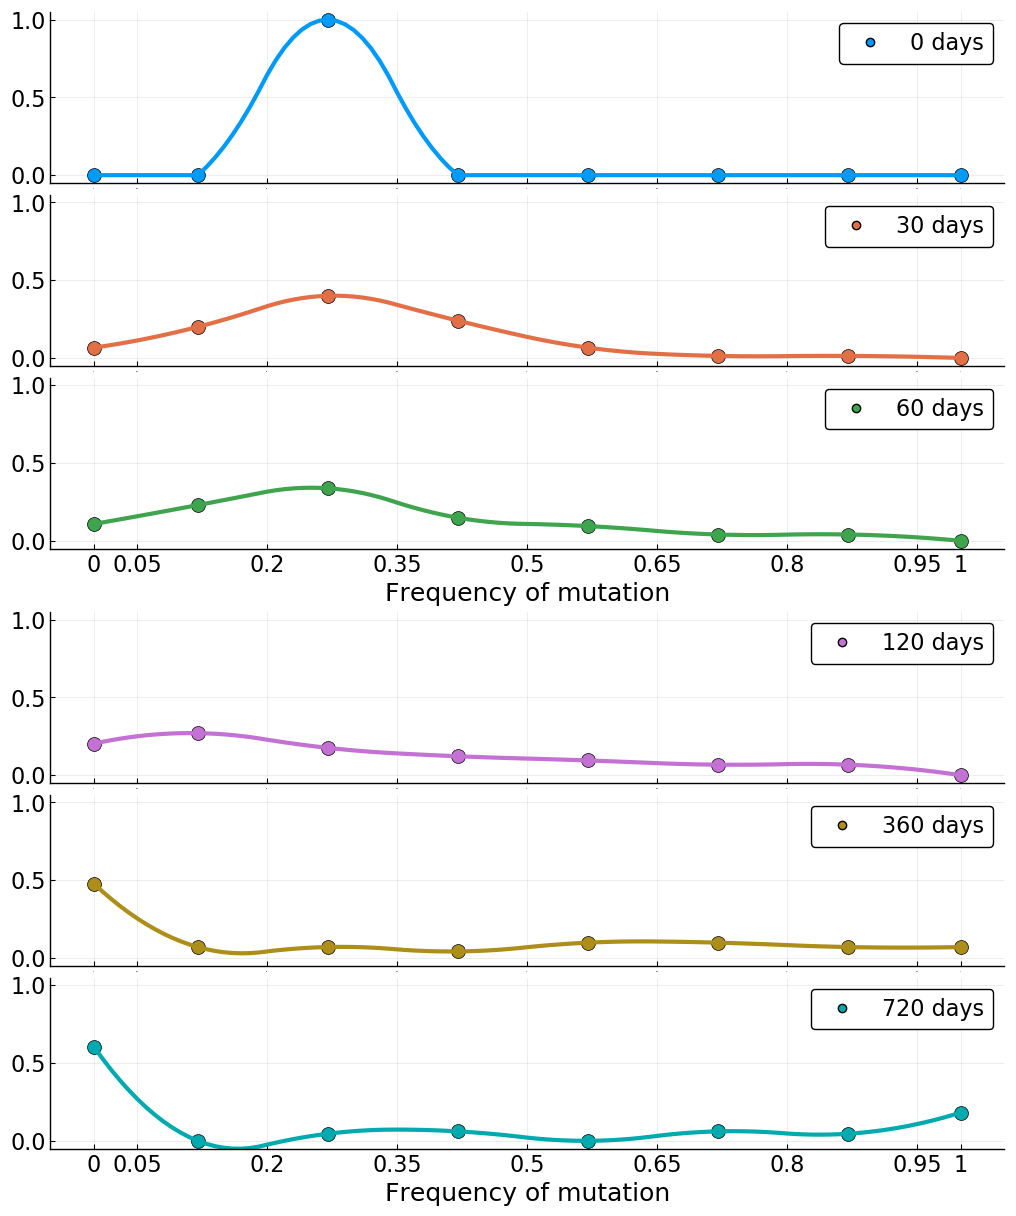

In [100]:
plot(pa..., layout=(length(pa),1), size=(1000,1200))
savefig("ShortTerm/Distribution_v_time_histograms.png")

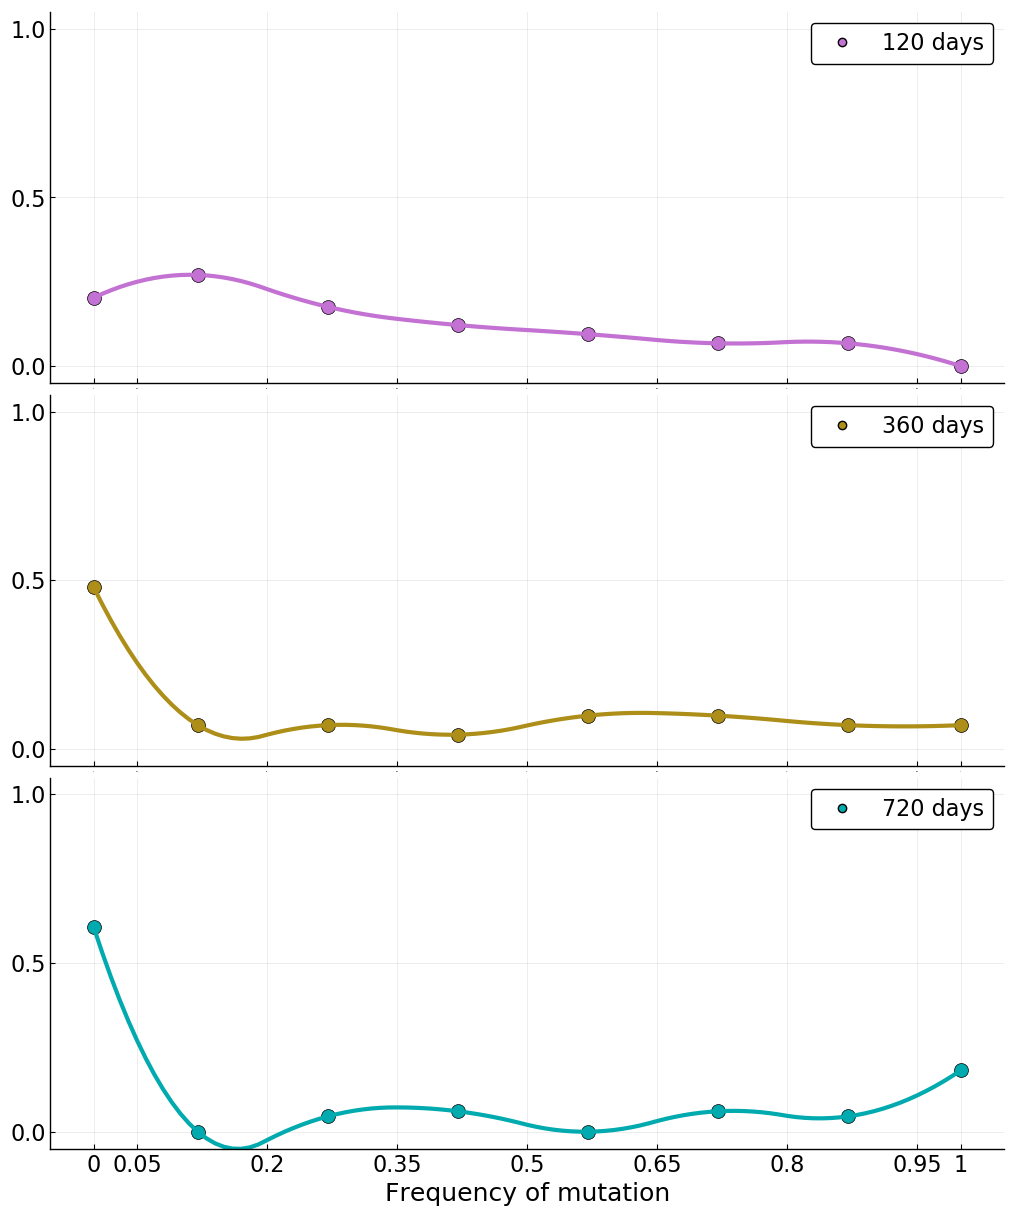

In [101]:
plot(pa[1:3]..., layout=(div(length(pa),2),1), size=(1000,1200))
savefig("ShortTerm/Distribution_v_time_histograms_2cols1.png")
plot(pa[4:6]..., layout=(div(length(pa),2),1), size=(1000,1200))
savefig("ShortTerm/Distribution_v_time_histograms_2cols2.png")

In [109]:
x = Int64[]
y = Float64[]
tidx = [-4,-2,0, 1, 2, 4, 6, 12, 24]
for traj in trajectories
    is = traj.index[:active]
    ie = is+3
    idx = is .+ tidx
    for (ii,i) in enumerate(idx)
        if i > length(traj.t)
            t = (i-is)*binspacing.value
            traj.fixation != :poly && push!(y, traj.fixation==:fixed ? 1. : 0.)
            traj.fixation != :poly && push!(x, ii)
        elseif i > 0
            push!(y, traj.freq[i])
            push!(x, ii)
        end
    end
end

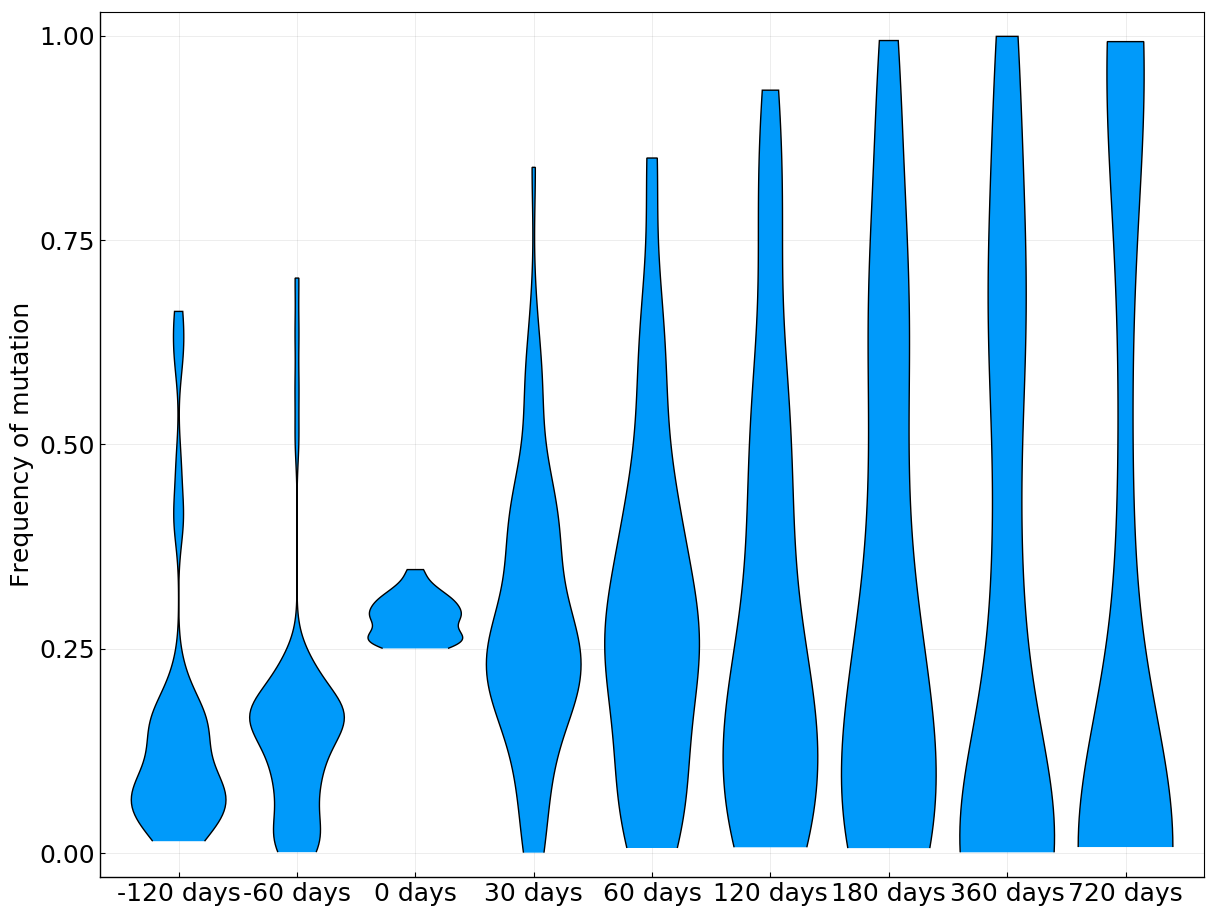

In [110]:
p = violin(x,y, label="")
plot!(p, xticks = (collect(1:length(tidx)), ["$(i*binspacing.value) days" for i in tidx]) )
# plot!(title="Days after observation")
plot!(ylabel="Frequency of mutation")
plot!(size=(1200,900), frame=:box, tickfontsize=atfs, guidefontsize=alfs)
savefig("ShortTerm/Distribution_v_time_violins.png")

In [ ]:
[x.freq]

In [1]:
p = violin(x,y, label="")
plot!(p, xticks = (collect(0:length(tidx)), ["$(i*binspacing.value) days" for i in tidx]) )
# plot!(title="Days after observation")
plot!(ylabel="Frequency of mutation")
plot!(size=(1200,900), frame=:box, tickfontsize=atfs, guidefontsize=alfs)


# 
nfix = length(findall(x->x.fixation==:fixed, trajectories))
nlost = length(findall(x->x.fixation==:lost, trajectories))
nactive = length(findall(x->x.fixation==:poly, trajectories))
fixflag = false; lostflag=false; actflag=false
for traj in trajectories
    if !ismissing(traj.index[:start]) && !ismissing(traj.index[:end])
        istart = traj.index[:active]; iend = traj.index[:end]
        idx = min.(istart .+ tidx, length(traj.t))
        if traj.fixation==:lost
            lab = lostflag ? "" : "Lost - $nlost"
            lostflag=true
            plot!(p, 0:length(idx), traj.freq[idx], label=lab, alpha=0.5, color=:black)
        elseif traj.fixation==:fixed
            lab = fixflag ? "" : "Fixed - $nfix"
            fixflag=true
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label=lab, alpha=0.5, color=:red)
        else
            lab = actflag ? "" : "Active - $nactive"
            actflag=true
            plot!(p, [x.value for x in traj.t[istart:iend]], traj.freq[istart:iend], label=lab, alpha=0.5, color=:black)
        end
    end
end
p

UndefVarError: UndefVarError: violin not defined

In [330]:
x.freq[x.index[:active]]

24

In [20]:
X,Y,Z = FluTools.frequency_plot(ph_all[241]);

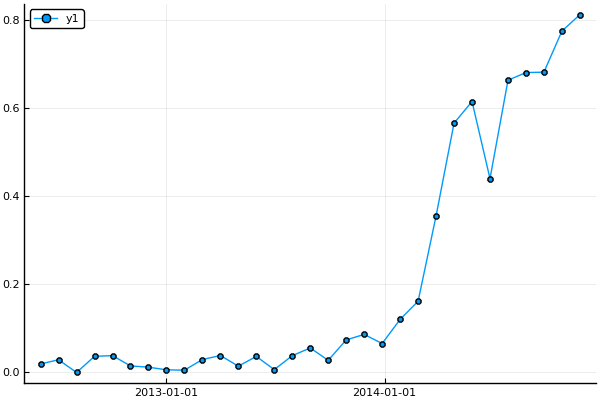

In [25]:
idx = 270:300
plot(X[idx],Y[idx,1], marker=:o)

In [23]:
length(X)

350